# Clustering FakeNewsNet

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

### Table of Contents
1. [Initial processing of the data set](#processing)
2. [Constructing a generic BuzzFeed featurizer](#featurizer)
3. [Analyzing the FakeNewsNet-BuzzFeed graph](#graph-analysis)

In [80]:
from typing import List
from pathlib import Path
from itertools import product
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
pd.options.future.infer_string = True

from tqdm import tqdm
import matplotlib.pyplot as plt
import math
plt.style.use('ggplot')

import networkx as nx
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import netwulf as nw
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from node2vec import Node2Vec

import re

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, f1_score, precision_score, recall_score, confusion_matrix

<a class="anchor" id="processing"></a>
## 1. Initial processing of the data set

Initially, the dataset will be loaded and processed before 1) $K$ train/test splits are created with the incentive to run cross-validation for getting the generalization error and 2) training and evaluating model performances. Through initial investigations we found that the provided PolitiFact data was corrupted in the sense that the text-content of fake- and real news were identical. For this reason, we restrict the analysis to the BuzzFeed dataset.

In [81]:
dataset     = 'BuzzFeed'

# Set path to data folder
DATA_DIR    = Path("../data")

### Text-based dataset

At first, we load the news- and user indices and construct a mapping between users and the news that they shared.

In [82]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}News.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}User.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}NewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(22779, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,45,1,1,BuzzFeed_Real_45,98d2b98ce305174e2f6c10b8f8a1a9d5
1,127,2,1,BuzzFeed_Fake_36,a273d0fd07c18a884ce2aa425813eb06
2,115,3,1,BuzzFeed_Fake_24,ac091e92df9e854a07563ffb397925d4
3,180,3,1,BuzzFeed_Fake_89,ac091e92df9e854a07563ffb397925d4
4,140,4,1,BuzzFeed_Fake_49,d2ded2de054f2ceb43dff7f80fc46774


Next we collect the fake- and real news in a single dataframe along with the respective news IDs.

In [83]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_real_news_content.csv', engine="pyarrow")
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)

# Add news id to dataframe
df['news_id']   = newsId

# Save processed data
df.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}NewsContent.csv', index=False)


### Word clouds of real and fake articles

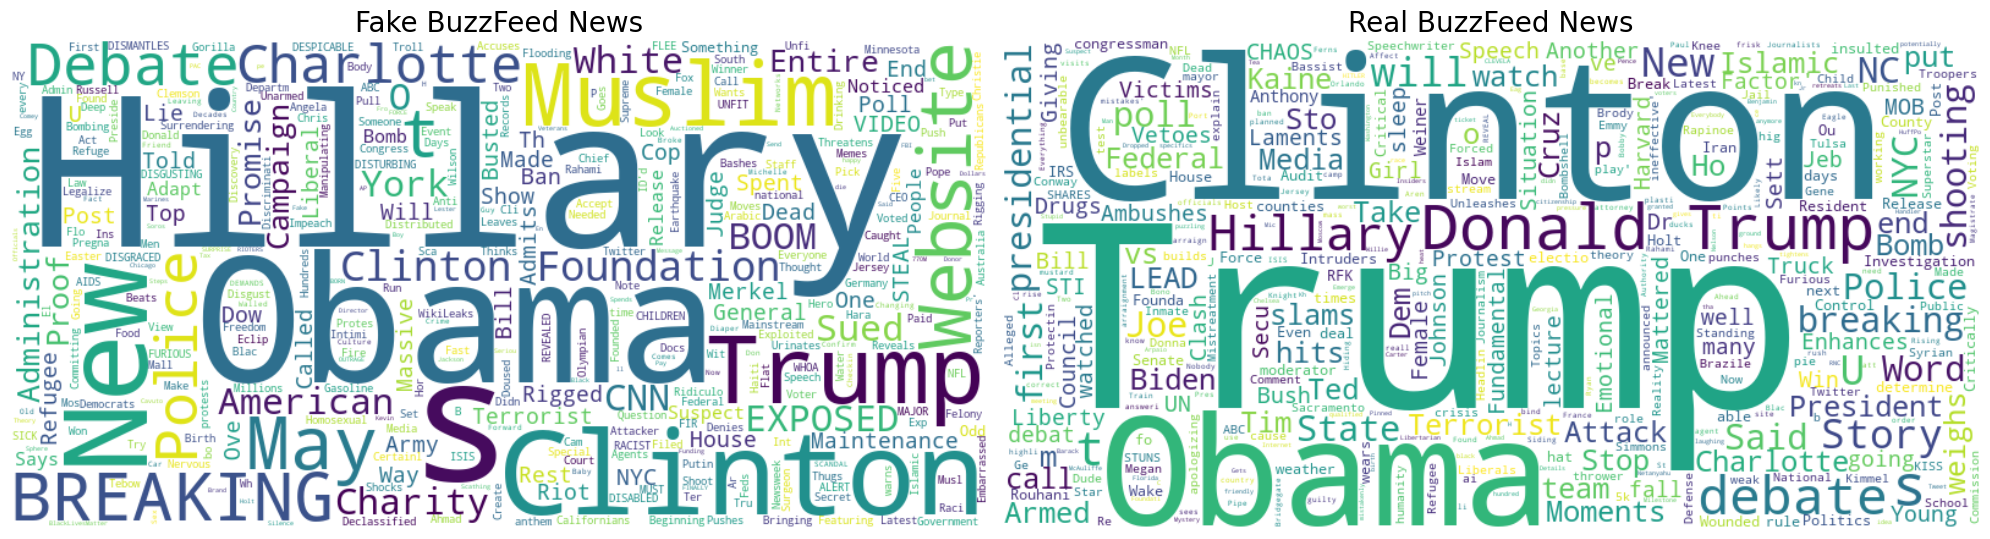

In [84]:
fake_news["full_text"] = fake_news["title"] + " " + fake_news["text"]
real_news["full_text"] = real_news["title"] + " " + real_news["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(fake_news["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(real_news["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake BuzzFeed News", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real BuzzFeed News", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.savefig("../reports/figures/BuzzFeedwordcloud.png", bbox_inches='tight')

plt.show()
del df, fake_news, real_news

### Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [69]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

In [70]:
# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 3002/3002 [00:10<00:00, 281.48it/s]


Now, we can construct the weighted edgelist and save it.

In [71]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv', index=False)
del weighted_edgelist

<a class="anchor" id="featurizer"></a>
## 2. Constructing a generic BuzzFeed featurizer

Next, we seek to construct a `BuzzFeedFeaturizer` object that contains functionalities for loading case-specific features (i.e. text- or graph variations) for each fold. This class along with auxiliary transformation functions are presented below.

In [72]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)

def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf


# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf']

def tf_idf(X_train, X_test):
    # TODO: implement TF-IDF transformation here...
    # TODO: make sure the format of the output is similar to that of transform_node2vec
    Xtrain, all_unique_words, idf = compute_tfidf_train(X_train, 'full_text')   

    Xtest = compute_tfidf_test(X_test, 'full_text', all_unique_words, idf) 

    # Convert the dictionaries in the "tfidf" column into a matrix
    dict_vectorizer = DictVectorizer(sparse=False)
    Xtrain = dict_vectorizer.fit_transform(Xtrain)
    Xtest = dict_vectorizer.transform(Xtest)

    return Xtrain, Xtest

def spectral_clustering(X):
    # TODO: implement spectral clustering here...
    # TODO: make sure the format of the output is similar to that of transform_node2vec
    return X

def transformer(X):
    # TODO: implement transformer here...
    # TODO: make sure the format of the output is similar to that of transform_node2vec
    return X

# Maybe
def fastText(X):
    # TODO: implement fastText here...
    # TODO: make sure the format of the output is similar to that of transform_node2vec
    return X

def transform_node2vec(G, train_idxs, test_idxs, dimensions: int = 32, walk_length: int = 10, num_walks: int = 100, window: int = 10, min_count: int = 1):   
    ### READ MORE ABOUT NODE2VEC HERE: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef ###
    
    np.random.seed(0)
    
    # Generate walks
    node2vec    = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, quiet=True)
    model       = node2vec.fit(window=window, min_count=min_count)

    # Get vector representations of splits
    train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in train_idxs}
    test2vec        = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in test_idxs}

    # Modify training split
    Xtrain          = np.array(list(train2vec.values()))
    ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in train_idxs]) 
    ytrain          = (ytrain == 'real').astype(int)

    # Modify test split
    Xtest           = np.array(list(test2vec.values()))
    ytest           = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in test_idxs])
    ytest           = (ytest == 'real').astype(int)
    
    return Xtrain, ytrain, Xtest, ytest


class BuzzFeedFeaturizer:

    def __init__(self, datapath: str, K: int = 10, seed=0):
        
        # Define inputs
        self.datapath       = datapath
        self.K              = K
        # Load datasets
        self.text       = self.load_text()
        self.full_graph = self.load_graph()
        self.labels     = pd.DataFrame(['Real' if 'real' in id_.lower() else 'Fake' for id_ in self.text['news_id']], index=self.text['news_id'])
        # Get dataset train/test splits for all folds
        self.split_indices  = self.get_split_indices(seed=seed)

    def get_split_indices(self, seed):
        np.random.seed(seed)

        # Permute all labels
        permuted_ids    = np.random.permutation(self.text['news_id'].unique())
        n_per_fold      = int(len(permuted_ids) / self.K)

        # Run splitting algorithm
        splits = {}
        for fold_ in range(self.K):
            test_ids        = permuted_ids[n_per_fold * fold_ : n_per_fold * (fold_ + 1)]
            train_ids       = np.setdiff1d(permuted_ids, test_ids)
            splits[fold_]   = {'test': test_ids, 'train': train_ids}
        return splits

    def load_text(self):
        # Load preprocessed text dataframe
        df = pd.read_csv(self.datapath / 'BuzzFeedNewsContent.csv')
        df["full_text"] = df["title"] + " " + df["text"]
        return df

    def load_graph(self):
        # Load edgelist of full network
        self.weighted_edgelist = pd.read_csv(self.datapath / f'BuzzFeed_full_graph_weighted_edgelist.csv')
        # Create networkx graph
        return nx.from_pandas_edgelist(self.weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)

    def get_feature_split(self, feature_mode: str, fold: int, seed: int = 42):
        np.random.seed(seed)

        # Get train and test ids
        train_idxs, test_idxs   = self.split_indices[fold]['train'], self.split_indices[fold]['test']

        ### TEXT REPRESENTATIONS ###
        if feature_mode in ['tf-idf', 'spectral_tf-idf', 'fasttext', 'bert']: # etc....
            Xtrain, Xtest           = self.text.query('news_id in @train_idxs'), self.text.query('news_id in @test_idxs')
            ytrain, ytest           = self.labels.query('news_id in @train_idxs'), self.labels.query('news_id in @test_idxs')

            # Get TF-IDF representations
            if feature_mode == 'tf-idf':
                Xtrain, Xtest       = tf_idf(Xtrain, Xtest)
            
            # Get spectral clustering representation
            if feature_mode == 'spectral_tf-idf':
                Xtrain              = spectral_clustering(Xtrain)
                Xtest               = spectral_clustering(Xtest)
                
                raise NotImplementedError('Spectral clustering not implemented!')
        
        ### GRAPH REPRESENTATIONS ###
        elif feature_mode in ['node2vec', 'spectral_graph']:
            if feature_mode == 'node2vec':
                Xtrain, ytrain, Xtest, ytest = transform_node2vec(self.full_graph, train_idxs, test_idxs)
                
            elif feature_mode == 'spectral_graph':
                raise NotImplementedError('Spectral graph clustering not implemented!')
                X_      = spectral_clustering(self.full_graph.adjacency_matrix()) # TODO: check this!

        return Xtrain, ytrain, Xtest, ytest

<a class="anchor" id="graph-analysis"></a>
## 3. Analyzing the FakeNewsNet-BuzzFeed graph

Before further exploring the featurizer, we verify that elements such as the full graph are stored in the object and run an initial analysis of the full graph.

Is the graph fully connected: True

Number of nodes: 	182
Number of edges: 	4772
Network diameter: 	4
Average shortest path: 	1.7663
Density: 		0.2897


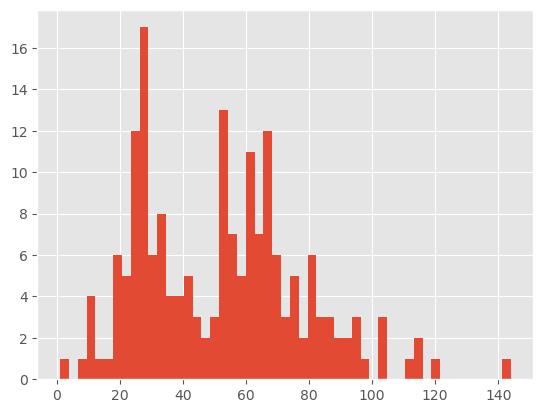

In [73]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=10)
G           = featurizer.full_graph

# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")
print(f"Density: \t\t{nx.density(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

As is seen, the network is quite dense in terms of links between nodes which can be seen from the degree distribution suggesting that most nodes have between 20-100 connections. This would immediately raise concerns regarding the task; namely that of predicting fake- or real news, since this could indicate that most nodes are connected to so many other nodes that there would be no clear distinction between the classes. However, visualizing the network using `netwulf` reveals a different finding, namely, that there is a somewhat apparent ground truth grouping of fake and real news with two minor intermediate groups with articles of limited degrees (size of nodes are degree). 

100%|██████████| 2/2 [00:00<?, ?it/s]


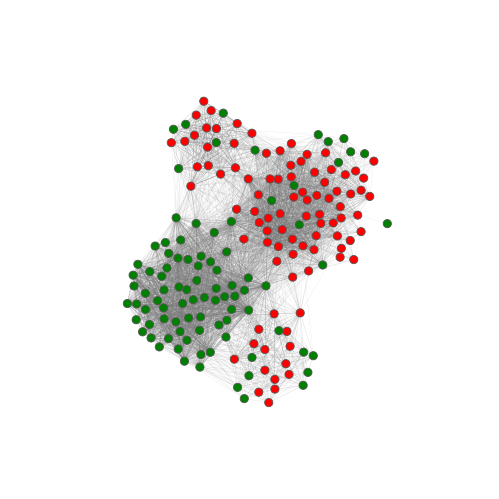

In [74]:
### UNCOMMENT TO GET GRAPH VISUALIZATION ! ### 

# Create ground truth partition
colors = ['green', 'red']
fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(fakenews_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

In [75]:
# Other statistics (node-wise)
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)

### Clustering - Louvain method

In [76]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.5468606050851721


100%|██████████| 5/5 [00:00<?, ?it/s]
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59932)
Traceback (most recent call last):
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\http\server.py", line 671, in __init__
    super().__init__(*args, **kwargs)
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "c:\Users\alber\Miniconda3\envs\02807\Lib\http\server.py", line 436, in handle
    self.handle_one_request()
  File "c

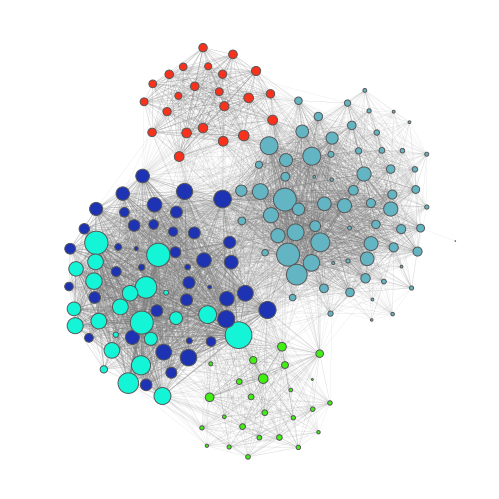

In [16]:
# ### UNCOMMENT TO GET GRAPH VISUALIZATION ! ###

# colors = [f"C{i}" for i in range(louvain_partition.__len__())]

# # Retrieve color codes on the node level
# viz_partition = {}
# for i, partition_ in enumerate(tqdm(louvain_partition)):
#     for node_ in partition_:
#         viz_partition[node_] = colors[i]

# # Set color codes on the node level
# nx.set_node_attributes(G, viz_partition, "group")

# # Visualize network
# stylized_network, config = nw.visualize(G)
# fig, ax = nw.draw_netwulf(stylized_network)
# plt.show()

In [145]:

def kmeans(**kwargs):
    # TODO: implement K-means algorithm from bottom...
    # TODO: make sure the format of the output is similar to what is seen below in the EvaluationModule.clustering function
    return {0: [kwargs['Xtrain'], kwargs['ytrain'], kwargs['Xtest'], kwargs['ytest']]}

def DBSCAN(**kwargs):
    # TODO: implement DBSCAN algorithm from bottom...
    # TODO: make sure the format of the output is similar to what is seen below in the EvaluationModule.clustering function
    raise NotImplementedError("TODO!")

def louvain(**kwargs):
    # albertkjoller: note - should be run on the graph and then train afterwards...
    # TODO: make sure the format of the output is similar to what is seen below in the EvaluationModule.clustering function
    raise NotImplementedError("TODO!")

# etc ...


class EvaluationModule:

    def __init__(
        self,
        featurizer: BuzzFeedFeaturizer,
        model: RandomForestClassifier,
        metrics: List[str] = ['SS', 'DBI', 'CHS', 'ARI', 'NMI', 'accuracy', 'weighted_f1_scores', 'precision', 'recall'],
        seed: int = 42,
    ):
        # Define featurizer and model
        self.featurizer         = featurizer
        self.model              = model
        # Setup evaluation metrics
        self.metrics            = metrics
        # Set seed
        self.seed               = seed
        
        # Whether run was triggered once
        self.run_count                  = 0
        self.previously_run_approaches  = []

        # Prepare prediction storage
        self.predictions        = defaultdict(dict)
        self.true_labels        = defaultdict(dict)
        self.feature_repr       = defaultdict(dict)

    def clustering(self, Xtrain, ytrain, Xtest, ytest, mode: str, **kwargs):

        if mode == 'KMeans': 
            # TODO: replace with own implementation...
            cls             = KMeans(n_clusters=kwargs['K_clusters'], random_state=self.seed, n_init=100)
            kmeans_train    = cls.fit_predict(Xtrain)
            kmeans_test     = cls.predict(Xtest)         
            return {k: [Xtrain[kmeans_train == k], ytrain[kmeans_train == k], Xtest[kmeans_test == k], ytest[kmeans_test == k]] for k in range(kwargs['K_clusters'])}
        elif mode == 'DBSCAN':
            raise NotImplementedError("TODO!")
        elif mode == 'HierarchicalClustering':
            raise NotImplementedError("TODO!")
        elif mode == 'SpectralClustering':
            raise NotImplementedError("TODO!")
        else:
            raise NotImplementedError('Specified clustering method not implemented!')
    
    def fit_predict(self, feature_mode: str, modeling_approaches: List[str] = ['baseline', 'global'], **kwargs):
        """
        Fit models and get predictions according to modeling_approaches input.

        Args:
            feature_mode (str): Which feature mode to use, e.g. 'tf-idf' or 'node2vec'.
            modeling_approaches (List[str], optional): The approaches to run. Defaults to ['baseline', 'global'].
        """

        if self.run_count == 0:
            self.module_feature_mode        = feature_mode
        else:
            assert feature_mode == self.module_feature_mode, "Can only run one feature mode per initialized EvaluationModule object..."

        # Run cross-validation
        for fold in tqdm(range(self.featurizer.K), desc='RUNNING CROSS-VALIDATION...'):
            Xtrain, ytrain, Xtest, ytest = self.featurizer.get_feature_split(feature_mode=feature_mode, fold=fold)

            # Loop through experiments
            for modeling_approach in np.setdiff1d(modeling_approaches, self.previously_run_approaches):
                if modeling_approach == 'baseline': 
                    # Define majority voting baseline
                    uniques, counts                     = np.unique(ytrain, return_counts=True)
                    majority_voter                      = uniques[np.argmax(counts)]
                    # Get predictions
                    self.predictions['baseline'][fold]  = majority_voter * np.ones(ytest.shape)
                    # Store true labels
                    self.true_labels['baseline'][fold]  = ytest
                    # Store true feature representations
                    self.feature_repr['baseline'][fold] = Xtest

                elif modeling_approach == 'global':
                    # Train model
                    self.model.fit(Xtrain, ytrain)
                    # Get predictions
                    self.predictions['global'][fold]    = self.model.predict(Xtest)
                    # Store true labels
                    self.true_labels['global'][fold]    = ytest
                    # Store true feature representations
                    self.feature_repr['global'][fold]   = Xtest

                else:
                    # Run clustering and get output
                    cluster_dict = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, K_clusters=kwargs['K_clusters'])

                    # Exploit local patterns
                    for cluster_idx, (Xtrain_c, ytrain_c, Xtest_c, ytest_c) in cluster_dict.items():
                        # Train local model
                        self.model.fit(Xtrain_c, ytrain_c)
                        # Get predictions
                        self.predictions[(modeling_approach, cluster_idx)][fold]    = self.model.predict(Xtest_c)
                        # Store true labels
                        self.true_labels[(modeling_approach, cluster_idx)][fold]    = ytest_c
                        # Store true feature representations
                        self.feature_repr[(modeling_approach, cluster_idx)][fold]   = Xtest_c

        # Update already run approaches
        self.previously_run_approaches  = np.union1d(modeling_approaches, self.previously_run_approaches)
        self.store_global_clustering_predictions(K_clusters=kwargs['K_clusters'])

    def store_global_clustering_predictions(self, K_clusters):

        # Add global KMeans labels to predictions
        for clustering_method in np.setdiff1d(self.previously_run_approaches, ['baseline', 'global']):
            for fold in range(self.featurizer.K):
                self.feature_repr[clustering_method][fold]  = np.concatenate([self.feature_repr[(clustering_method, k)][fold] for k in range(K_clusters)])
                self.true_labels[clustering_method][fold]   = np.concatenate([self.true_labels[(clustering_method, k)][fold] for k in range(K_clusters)])
                self.predictions[clustering_method][fold]   = np.concatenate([self.predictions[(clustering_method, k)][fold] for k in range(K_clusters)])

    def get_performance(self, **kwargs):
        results = defaultdict(dict)
        for fold in range(self.featurizer.K):
            
            # Store results
            results_fold = {}
            # Iterate through modeling approaches
            for modeling_approach in list(self.predictions.keys()):
                ypred = self.predictions[modeling_approach][fold]

                # Get test set
                Xtest = self.feature_repr[modeling_approach][fold]
                ytest = self.true_labels[modeling_approach][fold]
                
                # Compute and store results
                results_fold[modeling_approach] = {}
                results_fold[modeling_approach]['SS']                = silhouette_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['DBI']               = davies_bouldin_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['CHS']               = calinski_harabasz_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['ARI']               = adjusted_rand_score(ytest, ypred)
                results_fold[modeling_approach]['NMI']               = normalized_mutual_info_score(ytest, ypred)
                results_fold[modeling_approach]['accuracy']          = np.mean(ytest == ypred)
                results_fold[modeling_approach]['weighted_f1_score'] = f1_score(ytest, ypred, average='weighted')
                results_fold[modeling_approach]['precision']         = precision_score(ytest, ypred, average='weighted', zero_division=0.0)
                results_fold[modeling_approach]['recall']            = recall_score(ytest, ypred, average='weighted', zero_division=1.0)

            results[fold] = pd.DataFrame(results_fold)

        return results
        
    def latex_results(self, results):
        
        # Compute mean and sem across folds
        mean_ = np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)]).mean(axis=0)
        sems_ = np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)]).std(axis=0) / np.sqrt(self.featurizer.K)

        # Reformat as strings for proper latex display
        latex = np.ones(mean_.shape).astype(str)
        for i in range(mean_.shape[0]):
            for j in range(mean_.shape[1]):
                latex[i, j] = f"{mean_[i,j]:.3f} \pm {sems_[i,j]:.3f}"
        
        # Create dataframe
        df_latex    = pd.DataFrame(latex, columns=results[0].columns, index=results[0].index)
        mean_       = pd.DataFrame(mean_, columns=results[0].columns, index=results[0].index)
        sems_       = pd.DataFrame(sems_, columns=results[0].columns, index=results[0].index)

        return df_latex, mean_, sems_

In [146]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=10)
evaluator   = EvaluationModule(
    featurizer=featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 4
evaluator.fit_predict(feature_mode='node2vec', modeling_approaches=['baseline', 'global', 'KMeans'], K_clusters=K_clusters)

RUNNING CROSS-VALIDATION...:   0%|          | 0/10 [00:00<?, ?it/s]

RUNNING CROSS-VALIDATION...: 100%|██████████| 10/10 [02:38<00:00, 15.88s/it]


In [150]:
# Extract results from cross-validation
res_CV = evaluator.get_performance()

# Print latex results
res, mean, sem = evaluator.latex_results(res_CV)
print(res.to_latex())
res

\begin{tabular}{llllllll}
\toprule
 & ('KMeans', 0) & ('KMeans', 1) & ('KMeans', 2) & ('KMeans', 3) & baseline & global & KMeans \\
\midrule
SS & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & 0.224 \pm 0.024 & 0.216 \pm 0.024 \\
DBI & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & 1.599 \pm 0.118 & 1.600 \pm 0.127 \\
CHS & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & nan \pm nan & 5.362 \pm 0.714 & 5.056 \pm 0.757 \\
ARI & 0.300 \pm 0.145 & 0.700 \pm 0.145 & 0.600 \pm 0.155 & 0.423 \pm 0.150 & 0.000 \pm 0.000 & 0.429 \pm 0.076 & 0.382 \pm 0.081 \\
NMI & 0.300 \pm 0.145 & 0.700 \pm 0.145 & 0.634 \pm 0.145 & 0.438 \pm 0.149 & 0.000 \pm 0.000 & 0.417 \pm 0.072 & 0.382 \pm 0.075 \\
accuracy & 0.710 \pm 0.092 & 0.748 \pm 0.111 & 0.828 \pm 0.079 & 0.683 \pm 0.096 & 0.356 \pm 0.018 & 0.828 \pm 0.029 & 0.806 \pm 0.034 \\
weighted_f1_score & 0.658 \pm 0.099 & 0.704 \pm 0.124 & 0.786 \pm 0.092 & 0.651 \pm 0.106 & 0.189 \pm 0.017 & 0.826 \

,"(KMeans, 0)","(KMeans, 1)","(KMeans, 2)","(KMeans, 3)",baseline,global,KMeans
SS,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,0.224 \pm 0.024,0.216 \pm 0.024
DBI,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,1.599 \pm 0.118,1.600 \pm 0.127
CHS,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,nan \pm nan,5.362 \pm 0.714,5.056 \pm 0.757
ARI,0.300 \pm 0.145,0.700 \pm 0.145,0.600 \pm 0.155,0.423 \pm 0.150,0.000 \pm 0.000,0.429 \pm 0.076,0.382 \pm 0.081
NMI,0.300 \pm 0.145,0.700 \pm 0.145,0.634 \pm 0.145,0.438 \pm 0.149,0.000 \pm 0.000,0.417 \pm 0.072,0.382 \pm 0.075
accuracy,0.710 \pm 0.092,0.748 \pm 0.111,0.828 \pm 0.079,0.683 \pm 0.096,0.356 \pm 0.018,0.828 \pm 0.029,0.806 \pm 0.034
weighted_f1_score,0.658 \pm 0.099,0.704 \pm 0.124,0.786 \pm 0.092,0.651 \pm 0.106,0.189 \pm 0.017,0.826 \pm 0.029,0.802 \pm 0.034
precision,0.631 \pm 0.107,0.683 \pm 0.130,0.758 \pm 0.101,0.671 \pm 0.114,0.130 \pm 0.013,0.848 \pm 0.029,0.830 \pm 0.034
recall,0.710 \pm 0.092,0.748 \pm 0.111,0.828 \pm 0.079,0.683 \pm 0.096,0.356 \pm 0.018,0.828 \pm 0.029,0.806 \pm 0.034


In [56]:
# Option: add clusters by running
evaluator.fit_predict(feature_mode='node2vec', modeling_approaches=['spectral_graph'])

{0: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])}